# Classification by Wine Type, Part 2

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
red_wine = pd.read_csv('data/winequality-red.csv')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')

Since we completed our EDA in the [wine.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/wine.ipynb), we will just look at some rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
wine = pd.concat([
    white_wine.assign(kind='white'), red_wine.assign(kind='red')
])
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


## Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

wine_y = np.where(wine.kind == 'red', 1, 0)
wine_X = wine.drop(columns=['quality', 'kind'])

w_X_train, w_X_test, w_y_train, w_y_test = train_test_split(
    wine_X, wine_y, test_size=0.25, random_state=0, stratify=wine_y
)

## Logistic Regression Classification of Red and White Wines from Chapter 9

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

white_or_red = Pipeline([
    ('scale', StandardScaler()), ('lr', LogisticRegression(solver='lbfgs', random_state=0))
]).fit(w_X_train, w_y_train)

In [6]:
kind_preds = white_or_red.predict(w_X_test)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, kind_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1225
           1       0.99      0.98      0.98       400

   micro avg       0.99      0.99      0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



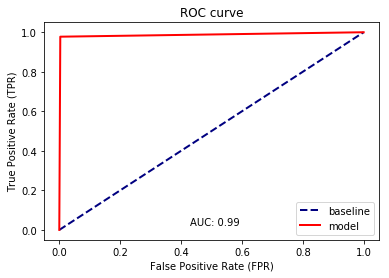

In [8]:
from utils import plot_roc

plot_roc(w_y_test, kind_preds)

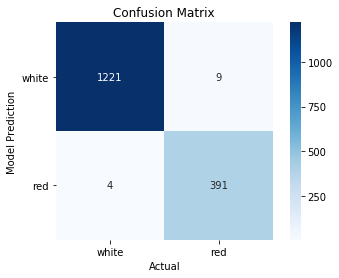

In [9]:
from utils import confusion_matrix_visual

confusion_matrix_visual(w_y_test, kind_preds, ['white', 'red'])

## Principal Components Analysis
Can we see a way to easily separate these that might help us?

Text(0.5, 0.98, 'Wine Kind PCA (2 components)')

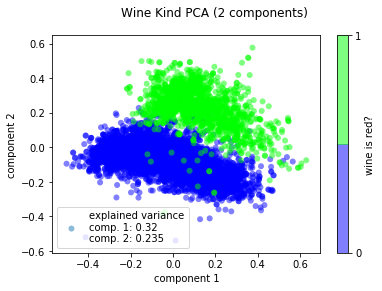

In [10]:
from utils import pca_scatter
pca_scatter(wine_X, wine_y, 'wine is red?')
plt.suptitle('Wine Kind PCA (2 components)')

Text(0.5, 0.98, 'Wine Type PCA (3 components)')

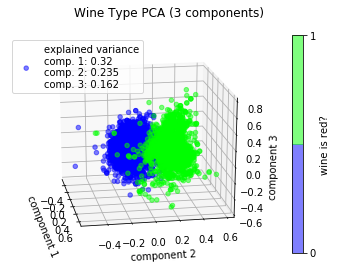

In [11]:
from utils import pca_scatter_3d
pca_scatter_3d(wine_X, wine_y, 'wine is red?', elev=20, azim=-10)
plt.suptitle('Wine Type PCA (3 components)')

### Will a model fit on these components perform better?

In [12]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('normalize', MinMaxScaler()),
    ('pca', PCA(3, random_state=0)),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
]).fit(w_X_train, w_y_train)

pipeline.named_steps['lr'].coef_

array([[ 4.89176165, 19.29435941,  2.30962526]])

In [13]:
# agreement with logistic regression alone
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(kind_preds, pipeline.predict(w_X_test))

0.9454229025347182

In [14]:
preds = pipeline.predict(w_X_test)
print(classification_report(w_y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1225
           1       0.95      0.96      0.96       400

   micro avg       0.98      0.98      0.98      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.98      0.98      0.98      1625



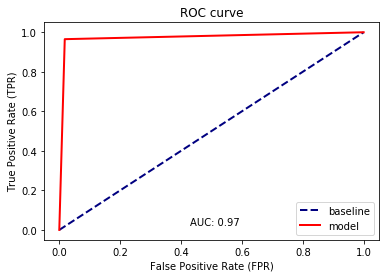

In [15]:
from utils import plot_roc
plot_roc(w_y_test, preds)

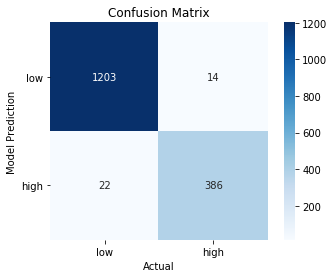

In [16]:
confusion_matrix_visual(w_y_test, preds, ['low', 'high'])

## Can a decision tree tell us what features are important?

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0).fit(w_X_train, w_y_train)
pd.DataFrame([(col, coef) for col, coef in zip(
    w_X_train.columns, dt.feature_importances_
)], columns=['feature', 'importance']
).set_index('feature').sort_values(
    'importance', ascending=False
).T

feature,total sulfur dioxide,chlorides,density,volatile acidity,sulphates,pH,residual sugar,alcohol,fixed acidity,citric acid,free sulfur dioxide
importance,0.687236,0.210241,0.050201,0.016196,0.012143,0.01143,0.005513,0.005074,0.001811,0.000113,0.000042


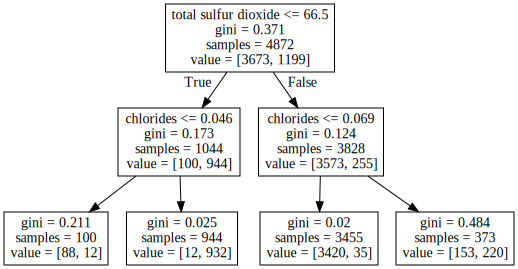

In [18]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(
    DecisionTreeClassifier(
        max_depth=2, random_state=0
    ).fit(w_X_train, w_y_train),
    feature_names=w_X_train.columns
))

### Visualizing the top 2 features

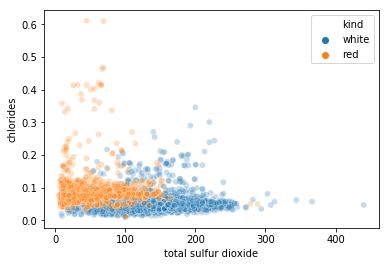

In [19]:
sns.scatterplot(x=wine['total sulfur dioxide'], y=wine['chlorides'], hue=wine.kind, alpha=0.25)

## Using Top 2 Features for Classification of Red and White Wines

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

important_features = ['total sulfur dioxide', 'chlorides']
X_train = w_X_train[important_features]
X_test = w_X_test[important_features]

white_or_red_top_features = Pipeline([
    ('scale', StandardScaler()), ('lr', LogisticRegression(solver='lbfgs', random_state=0))
]).fit(X_train, w_y_train)

### Notice our performance is still good.

In [21]:
top_features_kind_preds = white_or_red_top_features.predict(X_test)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(w_y_test, top_features_kind_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1225
           1       0.94      0.85      0.90       400

   micro avg       0.95      0.95      0.95      1625
   macro avg       0.95      0.92      0.93      1625
weighted avg       0.95      0.95      0.95      1625



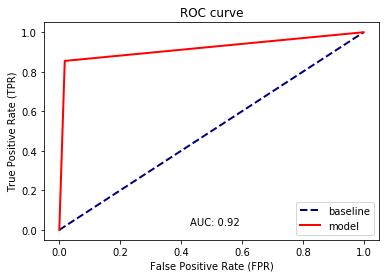

In [23]:
from utils import plot_roc

plot_roc(w_y_test, top_features_kind_preds)

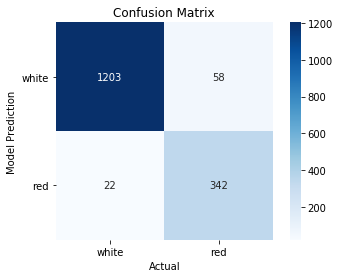

In [24]:
from utils import confusion_matrix_visual

confusion_matrix_visual(w_y_test, top_features_kind_preds, ['white', 'red'])

## Error Analysis on Logistic Regression

In [25]:
prediction_probabilities = pd.DataFrame(
    white_or_red.predict_proba(w_X_test), 
    columns=['prob_white', 'prob_red']
).assign(
    is_red=w_y_test == 1,
    pred_white=lambda x: x.prob_white >= 0.5, 
    pred_red=lambda x: np.invert(x.pred_white),
    correct=lambda x: (np.invert(x.is_red) & x.pred_white)\
    | (x.is_red & x.pred_red)
)

In [26]:
prediction_probabilities.sample(5, random_state=0)

,prob_white,prob_red,is_red,pred_white,pred_red,correct
443,0.994654,0.005346,False,True,False,True
319,0.999605,0.000395,False,True,False,True
703,0.000326,0.999674,True,False,True,True
526,0.999278,0.000722,False,True,False,True
76,0.999683,0.000317,False,True,False,True


### Distribution of prediction confidence

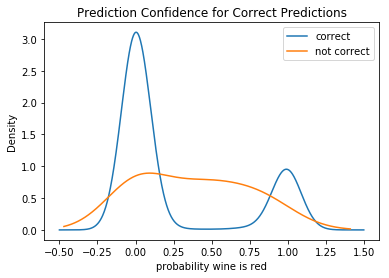

In [27]:
ax = None
for state in ['correct', 'not correct']:
    prediction_probabilities.query(state).prob_red.plot(
        kind='kde', label=state, ax=ax,
        title='Prediction Confidence for Correct Predictions'
    )
plt.xlabel('probability wine is red')
plt.legend()

### Are the incorrect classifications outliers?

Text(0.5, 0.98, "Comparing Chemical Properties of Red and White Wines\n(classification errors are red x's)")

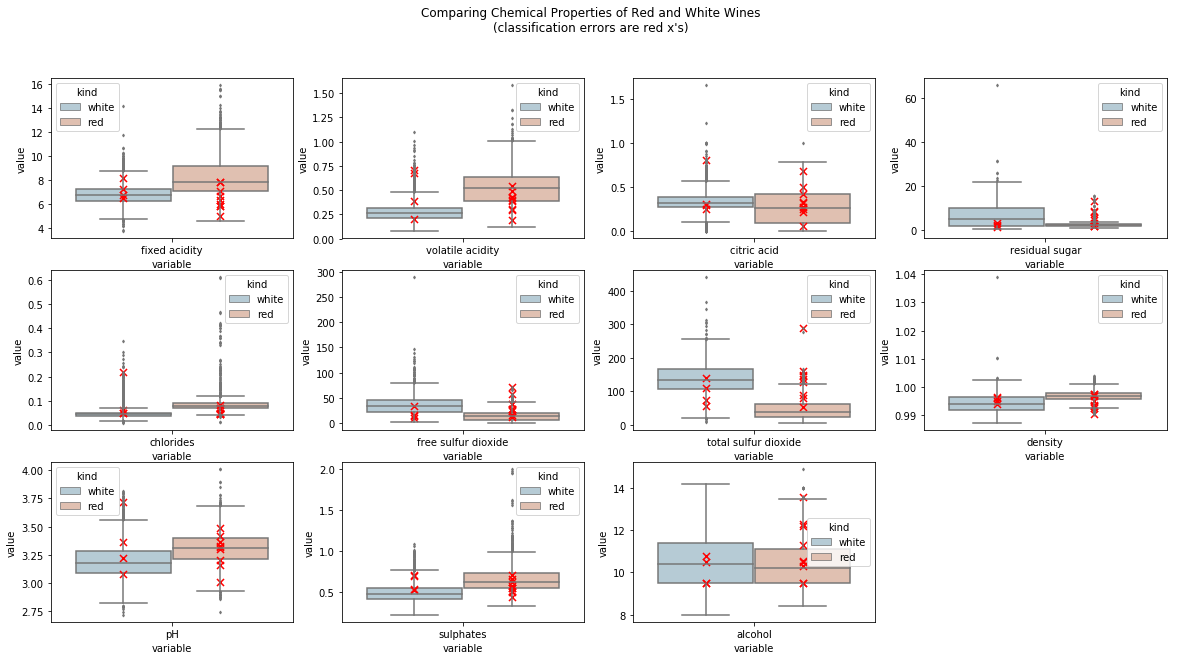

In [28]:
import math

incorrect = w_X_test.assign(is_red=w_y_test).iloc[prediction_probabilities.query('not correct').index,:]
chemical_properties = [col for col in wine.columns if col not in ['quality', 'kind']]
melted = wine.drop(columns='quality').melt(id_vars=['kind'])

fig, axes = plt.subplots(math.ceil(len(chemical_properties) / 4), 4, figsize=(20, 10))
axes = axes.flatten()

for prop, ax in zip(chemical_properties, axes):
    sns.boxplot(
        data=melted[melted.variable.isin([prop])], 
        x='variable', y='value', hue='kind', ax=ax,
        palette='RdBu_r', saturation=0.5, fliersize=2
    )
    for _, wrong in incorrect.iterrows():
        x_coord = -0.2 if not wrong['is_red'] else 0.2
        ax.scatter(x_coord, wrong[prop], marker='x', color='red', s=50)
    
# remove the extra subplots
for ax in axes[len(chemical_properties):]:
    ax.remove()
    
plt.suptitle(
    'Comparing Chemical Properties of Red and White Wines'
    '\n(classification errors are red x\'s)'
)